In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import datetime
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


In [2]:
import pandas as pd
Customer_df=pd.read_csv('/kaggle/input/onlineretail/OnlineRetail.csv',dtype={'CustomerID': str,'InvoiceID': str})
Customer_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
Customer_df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [4]:
#removing negative values and replacing them with zero
Customer_df.loc[Customer_df['Quantity']<0,'Quantity']=0
Customer_df.loc[Customer_df['UnitPrice']<0,'UnitPrice']=0

In [5]:
Customer_df[Customer_df.isnull().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [6]:
# drop rows with null values 
Customer_df=Customer_df.dropna(how='any',axis=0)
#Customer_df[Customer_df.isna().any(axis=1)]

In [7]:
Customer_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


In [8]:

Customer_df.InvoiceDate = pd.to_datetime(Customer_df.InvoiceDate)
#calculate the amount spent in each transaction
Customer_df['amount'] = Customer_df.Quantity*Customer_df.UnitPrice
# reference date is one day after transaction day so that the minimum recency is 1
refrence_date = Customer_df.InvoiceDate.max() + datetime.timedelta(days = 1)


In [9]:
# recency is the number of days since the reference date
Customer_df['recency'] = (refrence_date - Customer_df.InvoiceDate).astype('timedelta64[D]')
# recency per customer, finding the most recent purchase by the customer
Customer_Recency_df = Customer_df[['CustomerID', 'recency']].groupby("CustomerID").min().reset_index()
Customer_Recency_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,4372.0,92.047118,100.765435,1.0,17.0,50.0,143.0,374.0


In [10]:
#number of purchases per customer. group by invoice number because there might be multiple rows per customer per invoice.
Customer_freq = (Customer_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
Customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)


In [11]:
# amount: monetary value the amount spend by each customer
Customer_monetary_val = Customer_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
Customer_RFM =Customer_Recency_df.merge(Customer_freq).merge(Customer_monetary_val)
Customer_RFM.loc[Customer_RFM['amount']==0,'amount']=0.0001
Customer_RFM.describe()

,recency,frequency,amount
count,4372.000000,4372.000000,4372.000000
mean,92.047118,5.075480,2038.290921
std,100.765435,9.338754,8956.019171
min,1.000000,1.000000,0.000100
25%,17.000000,1.000000,303.602500
50%,50.000000,3.000000,665.315000
75%,143.000000,5.000000,1652.790000
max,374.000000,248.000000,280206.020000


In [12]:
# data is skewed so log transform and standard scaler helps to normalize it. 
Customer_RFM['recency_log'] = Customer_RFM['recency'].apply(math.log)
Customer_RFM['frequency_log'] =Customer_RFM['frequency'].apply(math.log)
Customer_RFM['amount_log'] =Customer_RFM['amount'].apply(math.log)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(Customer_RFM[['amount_log', 'recency_log','frequency_log']])


In [13]:

 
# used 4 clusters here but the number of clusters should be determined based on the Silhouette analysis
kmeans = KMeans(n_clusters=4, init="random", n_init=10, max_iter=300,random_state=42)
kmeans.fit(scaled_features)

# join the clusters to the main data
Customer_RFM['clusters_4'] = kmeans.labels_
cluster_centers=kmeans.cluster_centers_

In [14]:
display(Customer_RFM.head())
features = ['amount',  'recency',  'frequency']
scaler.inverse_transform(kmeans.cluster_centers_)
data_inversed = scaler.inverse_transform(cluster_centers)
data_transformed=pd.DataFrame(np.exp(data_inversed),columns=features)
data_transformed.reset_index(inplace=True)
data_transformed.rename(columns={"index": "Cluster"},inplace=True)

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_4
0,12346,326.0,2,77183.60,5.786897,0.693147,11.253942,3
1,12347,2.0,7,4310.00,0.693147,1.945910,8.368693,1
2,12348,75.0,4,1797.24,4.317488,1.386294,7.494007,3
3,12349,19.0,1,1757.55,2.944439,0.000000,7.471676,2
4,12350,310.0,1,334.40,5.736572,0.000000,5.812338,0


(0.0, 75.0)

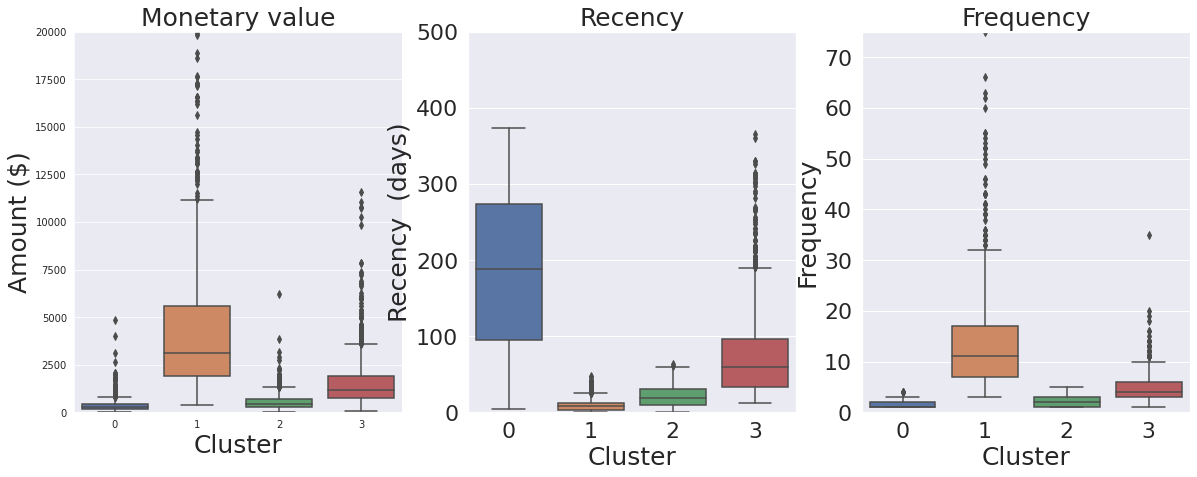

In [15]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
sns.set(font_scale =2)
ax1=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM['amount'])
ax1.set_title('Monetary value', fontsize = 25)
ax1.set_ylabel('Amount ($)', fontsize =25)
ax1.set_xlabel ('Cluster', fontsize = 25)
ax1.set_ylim(top=20000,bottom=0)

f1 = fig.add_subplot(132)
sns.set(font_scale = 2)
ax2=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM[ 'recency'])
ax2.set_title('Recency', fontsize =25)
ax2.set_ylabel('Recency  (days)', fontsize =25)
ax2.set_xlabel ('Cluster', fontsize = 25)
ax2.set_ylim(top=500,bottom=0)

f1 = fig.add_subplot(133)
sns.set(font_scale = 2)
ax3=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM[ 'frequency'])
ax3.set_title('Frequency', fontsize = 25)
ax3.set_ylabel('Frequency', fontsize =25)
ax3.set_xlabel ('Cluster', fontsize = 25)
ax3.set_ylim(top=75,bottom=0)


Cluster 0 is hibernating. Last purchase was long back, low spenders and low number of orders.  Action: Offer other relevant products and special discounts. Recreate brand value.

Cluster 1 are promising customers. Bought recently but didn’t spend much. Action: Create brand awareness, offer deals.

Cluster 2 are the champions. This group buy often, buy recently and spend the most. Action: Reward them. They can be early adopters of new products, and they can promote your brand. This group would be a good target for cross-sell/upsell.

Cluster 3 made big purchases, and often, but not recently! Win them back via newer products, don’t lose them to competition. 
